# Underestand Visitors with YOLO-World
---
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow/supervision/blob/develop/docs/notebooks/zero-shot-object-detection-with-yolo-world.ipynb)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/what-is-yolo-world/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/AILab-CVC/YOLO-World)
[![arXiv](https://img.shields.io/badge/arXiv-2401.17270-b31b1b.svg)](https://arxiv.org/abs/2401.17270)

Click the `Open in Colab` button to run the cookbook on Google Colab.

<br>

Understanding visitor behavior in malls, stores, and events is key to improving services and customer experience. With YOLO-World, we can now instantly identify specific visitor traits, like clothing colors or behaviors, without needing pre-trained data. This flexibility allows for tailored insights, enhancing how we manage and engage with visitors in any physical space.

![visualization results of referring object detection](https://storage.googleapis.com/adonaivera_certified/test.jpeg)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Fri Feb 16 22:18:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     Off | 00000000:01:00.0  On |                  N/A |
|  0%   35C    P8              10W / 285W |    789MiB / 12282MiB |     37%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/home/adonai/Documents/supervision/docs/notebooks


## Install required packages

In this guide, we utilize two Python packages: `inference`, for executing zero-shot object detection using YOLO-World, and `supervision`, for post-processing and visualizing the detected objects.

In [4]:
!pip install -q inference-gpu[yolo-world]==0.9.12rc1


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [5]:
!pip install -q supervision==0.19.0rc3


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Imports

In [6]:
import cv2
import supervision as sv

from tqdm import tqdm
from inference.models.yolo_world.yolo_world import YOLOWorld

[02/16/24 22:24:10] WARNING  Your inference package version 0.9.12rc1 is out of date! Please upgrade ]8;id=987691;file:///home/adonai/Documents/supervision/env/lib/python3.9/site-packages/inference/core/__init__.py\__init__.py]8;;\:]8;id=799287;file:///home/adonai/Documents/supervision/env/lib/python3.9/site-packages/inference/core/__init__.py#35\35]8;;\
                             to version 0.9.13 of inference for the latest features and bug fixes by               
                             running `pip install --upgrade inference`.                                            

## Download example data

In [77]:
!wget -P {HOME} -q https://storage.googleapis.com/adonaivera_certified/test.jpeg
!wget -P {HOME} -q https://storage.googleapis.com/adonaivera_certified/test_demo1.mp4

In [8]:
SOURCE_IMAGE_PATH = f"{HOME}/test.jpeg"
SOURCE_VIDEO_PATH = f"{HOME}/test_demo1.mp4"

**NOTE:** If you want to run the cookbook using your own file as input, simply upload video to Google Colab and replace `SOURCE_IMAGE_PATH` and `SOURCE_VIDEO_PATH` with the path to your file.

## Run Object Detection

The Inference package provides the YOLO-World model in three versions: `S`, `M`, and `L`. You can load them by defining model_id as `yolo_world/s`, `yolo_world/m`, and `yolo_world/l`, respectively. The `ROBOFLOW_API_KEY` is not required to utilize this model.







In [9]:
model = YOLOWorld(model_id="yolo_world/l")

YOLO-World is a zero-shot model, enabling object detection without any training. You only need to define a prompt as a list of classes (things) you are searching for.

In [10]:
classes = ["person"]
model.set_classes(classes)

We perform detection on our sample image. Then, we convert the result into a [`sv.Detections`](https://supervision.roboflow.com/latest/detection/core/) object, which will be useful in the later parts of the cookbook.

In [11]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.003)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

The results we've obtained can be easily visualized with [`sv.BoundingBoxAnnotator`](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.BoundingBoxAnnotator) and [`sv.LabelAnnotator`](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.LabelAnnotator). We can adjust parameters such as line thickness, text scale, line and text color allowing for a highly tailored visualization experience.

In [12]:
BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

By default, `sv.LabelAnnotator` displays only the names of objects. To also view the confidence levels associated with each detection, we must define custom `labels` and pass them to `sv.LabelAnnotator`.

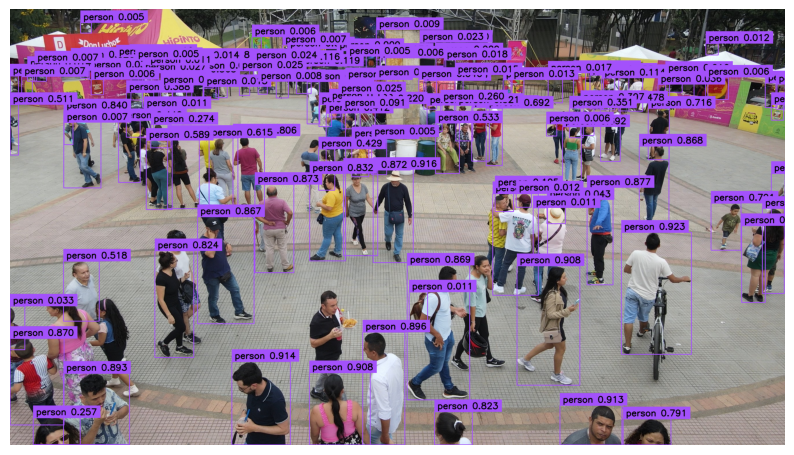

In [13]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))

## Make Special Search
Imagine you're the marketing director of a leading retail chain, tasked with decoding the behavior of your visitors. Picture one of your flagship stores in the mall, renowned for its exquisite collection of hats and backpacks. You're curious about the number of event attendees sporting hats and backpacks. Enter YOLO-World, a tool that simplifies this task, requiring no prior training. With YOLO-World, you can effortlessly gauge customer preferences and trends, enabling you to tailor your marketing strategies and inventory to better meet your customers' needs.

In [63]:

classes = ["person", "backpack", "persons with backpack", "persons with hats", "hats"]
model.set_classes(classes)

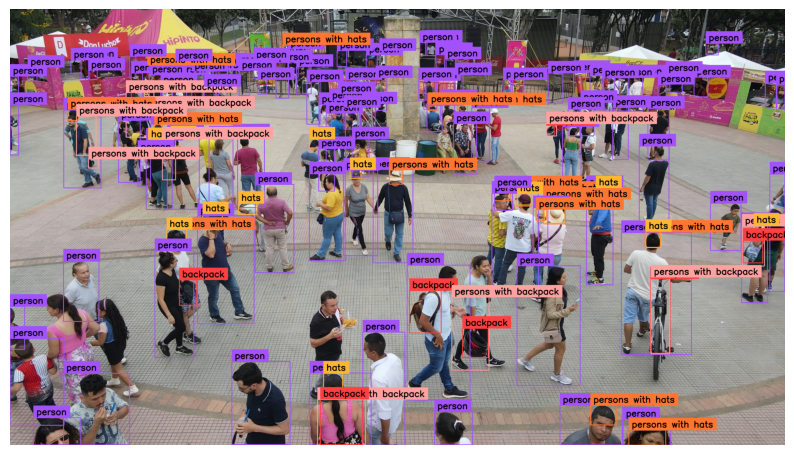

In [21]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.003)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))



## Saving Detections 

Now, at the end of the day would you like to see the final results and show to your supervisor all the metrics, but for that you need to save each of the prediction and after that you can create reports with the data.

We can use [`sv.CSVSink`](https://supervision.roboflow.com/develop/detection/tools/save_detections/) to save predictions. CSVSink allow to pass custom data alongside the detection fields, providing flexibility for logging various types of information.


In [69]:
csv_sink = sv.CSVSink('detections.csv')
csv_sink.open()

image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.003)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]


In [70]:
annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
csv_sink.append(detections, custom_data={'name_campaign': "hat and backpack"})

csv_sink.close()

## Display the results

In [71]:
import pandas as pd
df = pd.read_csv('detections.csv')
df

,x_min,y_min,x_max,y_max,class_id,confidence,tracker_id,class_name,name_campaign
0,1259.824402,556.843323,1397.988586,880.115173,0,0.922177,NaN,person,hat and backpack
1,1907.605164,1374.541077,2123.481262,1511.999939,0,0.920088,NaN,person,hat and backpack
2,185.341125,1263.053284,414.481201,1511.509705,0,0.917237,NaN,person,hat and backpack
3,1758.057983,890.935486,1977.167114,1305.461975,0,0.914720,NaN,person,hat and backpack
4,2120.903442,775.296661,2363.229370,1198.338348,0,0.913808,NaN,person,hat and backpack
...,...,...,...,...,...,...,...,...,...
145,415.074677,164.863037,436.987091,237.999908,0,0.011514,NaN,person,hat and backpack
146,543.731293,764.712311,611.070221,820.007904,4,0.010440,NaN,hats,hat and backpack
147,945.790405,124.706638,977.625732,162.100552,3,0.010306,NaN,persons with hats,hat and backpack
148,1532.029236,999.259613,1661.712952,1252.837067,2,0.010227,NaN,persons with backpack,hat and backpack


## Final Result
Imagine taking it a step further as the marketing director of a premier retail conglomerate, aiming to expand your insights across the entire mall. You're not just analyzing static images anymore; you're delving into the dynamic world of video analysis. With YOLO-World, you can now process continuous video streams, capturing the ebb and flow of visitor behaviors and preferences in real-time. This leap from image to video processing opens up a new dimension of understanding, allowing you to observe trends, track movements, and gather nuanced insights into how visitors interact with different spaces within the mall. This powerful capability empowers you to refine the shopping experience, optimize store layouts, and develop targeted marketing campaigns that resonate with your audience on a whole new level.

In [78]:
TARGET_VIDEO_PATH = f"{HOME}/test_demo_result.mp4"

In [79]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
csv_sink = sv.CSVSink('detections.csv')


with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink, csv_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        results = model.infer(frame, confidence=0.002)
        detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

        annotated_frame = frame.copy()
        annotated_frame = BOUNDING_BOX_ANNOTATOR.annotate(annotated_frame, detections)
        annotated_frame = LABEL_ANNOTATOR.annotate(annotated_frame, detections)
        sink.write_frame(annotated_frame)
        csv_sink.append(detections, custom_data={'name_campaign': "hat and backpack"})

 87%|████████▋ | 173/199 [00:16<00:02, 10.77it/s]


 Keep in mind that the video preview below works only in the web version of the cookbooks and not in Google Colab.

<video controls>
    <source
        src="https://storage.googleapis.com/tecla/results_yolo_world.mp4"
        type="video/mp4"
    >
</video>